<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Diego Alberto López Lazareno, Andrea Flores Fernández.

**Fecha:** 24 de noviembre del 2021.

**Expediente** : 722100, 725449.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/diegolazareno/Tarea10_DALopez_AFlores

# Tarea 10: Clase 24

## Enunciado de tarea 

**Realizar la valuación de las opciones barrera para las acciones de Microsoft**, siguiendo los siguientes lineamientos:

1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

### Ejercicio 1

> Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.

`Estudiante 1 : Diego`

In [1]:
# Librerías necesarias
import pandas as pd
import numpy as np
from datetime import date
import yfinance as yf
from scipy import stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Funciones necesarias
def options_yf(ticker : "Ticker en formato string"):
    """
    options_yf descarga información de opciones financieras con ayuda de yfinance. Retorna:
    *calls : un diccionario con los calls a distintas fechas de vencimiento.
    *puts : un diccionario con los puts a distintas fechas de vencimiento.
    
    *ticker : es el símbolo de cotización de la acción
    
    """
    stock = yf.Ticker(ticker)
    calls, puts = {}, {}
    
    def options_yf_(n):
        nonlocal stock
        calls[stock.options[n]] = stock.option_chain(stock.options[n])[0]
        puts[stock.options[n]] = stock.option_chain(stock.options[n])[1]
    
    [options_yf_(n) for n in range(len(stock.options))]
    
    return calls, puts

def returns(closes : "Precios de cierre ajustados de una acción"):
    "returns calcula los rendimientos logarítmicos del precio de una acción"
    
    return np.log(closes / closes.shift(1)).dropna()

def modeloNormal(expiry : "Fecha de expiración del contrato", strike : "Precio de ejercicio",
                     sigma : "Volatilidad", rf : "Tasa libre de riesgo", S0 : "Precio inicial", option : "Call, Put"):
    """
    modeloNormal elabora la valoración de una opción financiera a través del Modelo de los Rendimientos Normales.
    
    *expiry : es la fecha de expiración del contrato.
    *strike : es el precio de ejercicio del contrato.
    *sigma : es la volatilidad del activo subyacente.
    *rf : es la tasa libre de riesgo (base diaria).
    *S0 : es el precio inicial del activo subyacente.
    *option : es el tipo de opción, Call o Put.
    
    """
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq = 'B')
    ndays = len(dates)
    nscen = 10000
    
    sim_ret = pd.DataFrame(sigma * np.random.randn(ndays, nscen) + rf, index = dates)
    simulations = S0 * np.exp(sim_ret.cumsum())
    simulations.iloc[0, :] = S0
        
    if option == "Call":
        I = (simulations < b).cumsum(axis = 0) == 0
        opcionEuropea = pd.DataFrame({'Prima Europea' : np.exp(-rf * ndays) * np.fmax(simulations - strike, 0).mean(axis = 1)}, 
                           index = dates)
        opcionBarrera = pd.DataFrame({'Prima Down-And-Out' : 
                                np.exp(-rf * ndays) * (I * np.fmax(simulations - strike, 0)).mean(axis = 1)},
                           index = dates)
    else:
        I = (simulations < b).cumsum(axis = 0) == 0
        opcionEuropea = pd.DataFrame({'Prima Europea' : np.exp(-rf * ndays) * np.fmax(simulations - strike, 0).mean(axis = 1)}, 
                           index = dates)
        opcionBarrera = pd.DataFrame({'Prima Down-And-Out' : 
                                np.exp(-rf * ndays) * (I * np.fmax(simulations - strike, 0)).mean(axis = 1)},
                           index = dates)
    
    return opcionEuropea, opcionBarrera, simulations

def histograma(expiry : "Fecha de expiración del contrato", strike : "Precio de ejercicio",
                      returns : "Rendimientos", mu : "Rendimiento esperado", sigma : "Volatilidad", 
                      rf : "Tasa libre de riesgo", S0 : "Precio inicial", option : "Call, Put"):
    """
    histograma elabora la valoración de una opción financiera a través del Método del Histograma.
    
    *expiry : es la fecha de expiración del contrato.
    *strike : es el precio de ejercicio del contrato.
    *returns : son los rendimientos logarítmicos de la acción.
    *mu : es el rendimiento esperado del activo subyacente.
    *sigma : es la volatilidad del activo subyacente.
    *rf : es la tasa libre de riesgo (base diaria).
    *S0 : es el precio inicial del activo subyacente.
    *option : es el tipo de opción, Call o Put.
    
    """
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq = 'B')
    ndays = len(dates)
    nscen = 10000
    
    freq, values = np.histogram(returns - mu + rf, bins = 10000)
    prob = freq / np.sum(freq)
    ret = np.random.choice(values[1:], (ndays, nscen), p = prob)
    sim_ret_hist = pd.DataFrame(ret, index = dates)
    simulations = S0 * np.exp(sim_ret_hist.cumsum())
    simulations.iloc[0, :] = S0
    
    if option == "Call":
        I = (simulations < b).cumsum(axis = 0) == 0
        opcionEuropea = pd.DataFrame({'Prima Europea' : np.exp(-rf * ndays) * np.fmax(simulations - strike, 0).mean(axis = 1)}, 
                           index = dates)
        opcionBarrera = pd.DataFrame({'Prima Down-And-Out' : 
                                np.exp(-rf * ndays) * (I * np.fmax(simulations - strike, 0)).mean(axis = 1)},
                           index = dates)
    else:
        I = (simulations < b).cumsum(axis = 0) == 0
        opcionEuropea = pd.DataFrame({'Prima Europea' : np.exp(-rf * ndays) * np.fmax(simulations - strike, 0).mean(axis = 1)}, 
                           index = dates)
        opcionBarrera = pd.DataFrame({'Prima Down-And-Out' : 
                                np.exp(-rf * ndays) * (I * np.fmax(simulations - strike, 0)).mean(axis = 1)},
                           index = dates)
    
    return opcionEuropea, opcionBarrera, simulations


def confidenceInterval(option : "Primas de la opción", simulations : "Precios simulados", method : "Tipo de opción"):
    """
    confidenceInterval computa un intervalo de confianza para la prima de una opción (europea o barrera).
    
    *options : son las primas de la opción.
    *simulations : son los precios simulados.
    *method : es el tipo de opción.
    
    """
    
    ci = st.norm.interval(0.99, loc = option.iloc[-1].values[0], scale = st.sem(simulations.iloc[-1]))
    results = pd.DataFrame({"Prima" : option.iloc[-1].values[0], "Límite inferior (99% confianza)" : ci[0],
                            "Límite superior (99% confianza)" : ci[1]}, index = [method])
    return results


In [2]:
# Descarga inicial de precios e información de opciones con yfinance
ticker = "MSFT"
start = "2017-11-01"
prices = yf.download(ticker, start = start, end = None, progress = False)["Adj Close"]
calls, puts = options_yf(ticker)

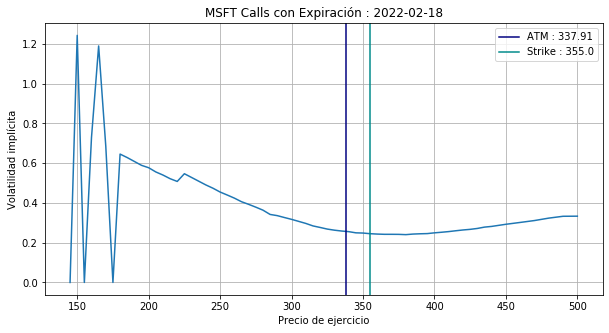

In [3]:
# Fecha de expiración del contrato
fechaExpiracion = "2022-02-18"

# Visualización de la sonrisa de volatilidad
plt.figure(figsize = (10, 5))
plt.title(ticker + " Calls con Expiración : " + fechaExpiracion)
plt.plot(calls[fechaExpiracion]["strike"], calls[fechaExpiracion]["impliedVolatility"])
plt.axvline(prices[-1], color = "navy", label = "ATM : " + str(round(prices[-1], 2)))

idx = calls[fechaExpiracion][(calls[fechaExpiracion]["strike"] > prices[-1]) & 
                             (calls[fechaExpiracion]["strike"] < 360)]["impliedVolatility"].idxmin()
strike = calls[fechaExpiracion].loc[idx, "strike"]
plt.axvline(strike, color = "darkcyan", label = "Strike : " + str(strike))

plt.ylabel("Volatilidad implícita")
plt.xlabel("Precio de ejercicio")
plt.legend(loc = "best")
plt.grid();

## Call Down And Out

+ Call para Microsoft (MSFT)
+ Fecha de Expiración : $2022-02-18$
+ Precio de Ejercicio ($K$) : $\$355$
+ Barrera ($B$) : $\$320$
+ Función de Pago : $max(S_T - K, 0) \space I(B < S_T) = max(S_T - 355, 0) \space I(320 < S_T)$

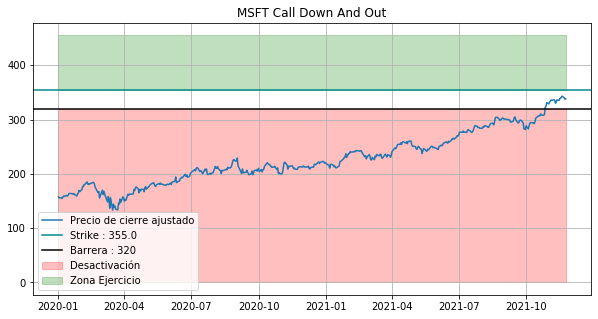

In [4]:
# Barrera
b = 320

# Visualización del Call Down And Out
plt.figure(figsize = (10, 5))
plt.title(ticker + " Call Down And Out")
plt.plot(prices[prices.index > "2020-01-01"], label = "Precio de cierre ajustado")
plt.axhline(strike, color = "darkcyan", label = "Strike : " + str(strike))
plt.axhline(b, color = "k", label = "Barrera : " + str(b))
plt.fill_between(prices[prices.index > "2020-01-01"].index, b, color = "red", alpha = 0.25, label = "Desactivación")
plt.fill_between(prices[prices.index > "2020-01-01"].index, strike, strike + 100, color = "green", 
                 alpha = 0.25, label = "Zona Ejercicio")
plt.legend(loc = "best")
plt.grid();

### Valoración por el Modelo de Rendimientos Normales

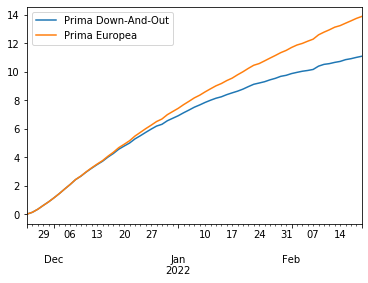

In [5]:
msftReturns = returns(prices)
mu = msftReturns.mean() 
sigma = msftReturns.std()
rf = 0.0024 / 360

callEuropeo, callBarrera, simulations = modeloNormal(fechaExpiracion, strike, sigma, rf, prices[-1], "Call")
ax = callBarrera.plot();
callEuropeo.plot(ax = ax);

In [6]:
confidenceInterval(callEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,13.869781,12.584772,15.154789


In [7]:
confidenceInterval(callBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,11.076234,9.791226,12.361243


### Valoración por el Método del Histograma

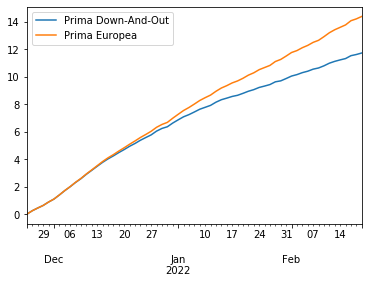

In [8]:
callEuropeo, callBarrera, simulations = histograma(fechaExpiracion, strike, msftReturns, mu, sigma, rf, prices[-1], "Call")
ax = callBarrera.plot();
callEuropeo.plot(ax = ax);

In [9]:
confidenceInterval(callEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,14.375019,13.077621,15.672417


In [10]:
confidenceInterval(callBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,11.717223,10.419825,13.014621


`Estudiante 2 : Andrea`

### Ejercicio 2

> Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

`Estudiante 1 : Diego`

`Estudiante 2 : Andrea`